# Классификация "Лошадь или Человек" с использованием CNN

In [32]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, ConcatDataset, random_split
import torchvision.transforms as T
import torchvision.datasets as datasets
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, roc_curve
from PIL import Image
import opendatasets as od

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Device:", device)

RANDOM_SEED = 42
torch.manual_seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)

Device: cuda


In [11]:
os.environ['KAGGLE_USERNAME'] = "dka2004"
os.environ['KAGGLE_KEY'] = "26436839"
dataset_url = 'https://www.kaggle.com/datasets/sanikamal/horses-or-humans-dataset'
od.download(dataset_url)

data_path = 'horses-or-humans-dataset/horse-or-human'
train_dir = os.path.join(data_path, 'train')
val_dir = os.path.join(data_path, 'validation')

IMG_SIZE = 150

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username:Your Kaggle Key:Dataset URL: https://www.kaggle.com/datasets/sanikamal/horses-or-humans-dataset


100%|██████████| 307M/307M [00:00<00:00, 2.03GB/s]

Аугментация и базовые преобразования

In [12]:
augment_transforms = T.Compose([
    T.Resize((IMG_SIZE, IMG_SIZE)),
    T.RandomHorizontalFlip(),
    T.RandomRotation(15),
    T.ColorJitter(0.3, 0.3, 0.3, 0.1),
    T.RandomPerspective(distortion_scale=0.2, p=0.5),
    T.GaussianBlur(kernel_size=3),
    T.ToTensor()
])

base_transforms = T.Compose([
    T.Resize((IMG_SIZE, IMG_SIZE)),
    T.ToTensor()
])

Создание датасетов

In [13]:
train_base = datasets.ImageFolder(root=train_dir, transform=base_transforms)
val_base = datasets.ImageFolder(root=val_dir, transform=base_transforms)

augmented_datasets = [train_base]
for _ in range(3):
    augmented_datasets.append(datasets.ImageFolder(root=train_dir, transform=augment_transforms))

train_dataset = ConcatDataset(augmented_datasets)

all_data = ConcatDataset([train_base, val_base])
test_size = int(0.2 * len(all_data))
train_size = len(all_data) - test_size
train_dataset, test_dataset = random_split(all_data, [train_size, test_size])

BATCH_SIZE = 32
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, num_workers=2)

Визуализация нескольких изображений

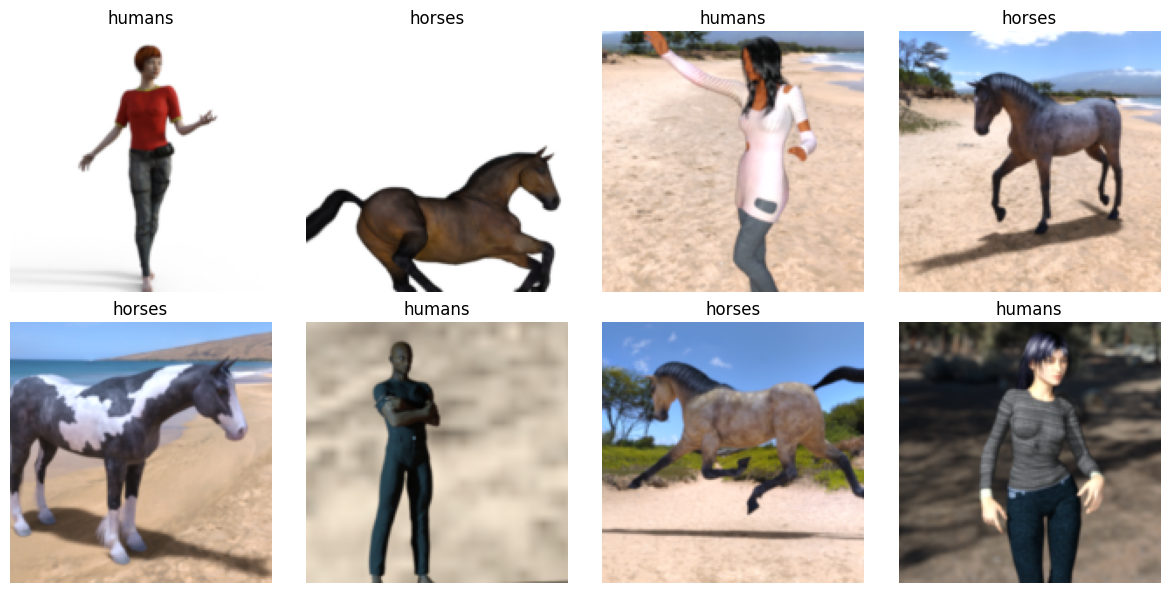

In [14]:
class_names = train_base.classes

def show_images(batch, labels):
    fig, axs = plt.subplots(2, 4, figsize=(12,6))
    axs = axs.ravel()
    for i in range(8):
        img = batch[i].numpy().transpose(1,2,0)
        axs[i].imshow(img)
        axs[i].set_title(class_names[labels[i]])
        axs[i].axis('off')
    plt.tight_layout()
    plt.show()

images, labels = next(iter(train_dataloader))
show_images(images, labels)

Определение CNN

In [15]:
class HorseHumanCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(3, 16, 3, padding=1), nn.BatchNorm2d(16), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(16, 32, 3, padding=1), nn.BatchNorm2d(32), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(32, 64, 3, padding=1), nn.BatchNorm2d(64), nn.ReLU(), nn.MaxPool2d(2)
        )
        self.fc_layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64*18*18, 64),
            nn.Dropout(0.6),
            nn.ReLU(),
            nn.Linear(64, 1),
            nn.Sigmoid()
        )
    def forward(self, x):
        x = self.conv_layers(x)
        x = self.fc_layers(x)
        return x

model = HorseHumanCNN().to(device)

Функции обучения и валидации

In [16]:
def train_one_epoch(model, dataloader, criterion, optimizer, device):
    model.train()
    total_loss, correct, total = 0, 0, 0
    for data, target in dataloader:
        data, target = data.to(device), target.to(device).float().unsqueeze(1)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        pred = (output>0.5).float()
        correct += (pred==target).sum().item()
        total += target.size(0)
    return total_loss/len(dataloader), correct/total

def validate_one_epoch(model, dataloader, criterion, device):
    model.eval()
    total_loss, correct, total = 0, 0, 0
    all_probs, all_targets = [], []
    with torch.no_grad():
        for data, target in dataloader:
            data, target = data.to(device), target.to(device).float().unsqueeze(1)
            output = model(data)
            loss = criterion(output, target)
            total_loss += loss.item()
            pred = (output>0.5).float()
            correct += (pred==target).sum().item()
            total += target.size(0)
            all_probs.extend(output.cpu().numpy())
            all_targets.extend(target.cpu().numpy())
    auc = roc_auc_score(all_targets, all_probs)
    return total_loss/len(dataloader), correct/total, auc, all_probs, all_targets

Обучение модели

In [17]:
criterion = nn.BCELoss()
optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=0.01)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

num_epochs = 5
train_loss_list, val_loss_list = [], []
train_acc_list, val_acc_list = [], []
auc_list = []

for epoch in range(num_epochs):
    train_loss, train_acc = train_one_epoch(model, train_dataloader, criterion, optimizer, device)
    val_loss, val_acc, auc, probs, targets = validate_one_epoch(model, test_dataloader, criterion, device)
    scheduler.step()
    
    train_loss_list.append(train_loss)
    val_loss_list.append(val_loss)
    train_acc_list.append(train_acc)
    val_acc_list.append(val_acc)
    auc_list.append(auc)
    
    print(f"Epoch {epoch+1}/{num_epochs}: Train Acc {train_acc:.4f}, Val Acc {val_acc:.4f}, ROC-AUC {auc:.4f}")

Epoch 1/5: Train Acc 0.8588, Val Acc 0.7188, ROC-AUC 0.7677
Epoch 2/5: Train Acc 0.9474, Val Acc 0.8750, ROC-AUC 0.9874
Epoch 3/5: Train Acc 0.9299, Val Acc 0.8906, ROC-AUC 0.9915
Epoch 4/5: Train Acc 0.9591, Val Acc 0.9844, ROC-AUC 0.9966
Epoch 5/5: Train Acc 0.9649, Val Acc 0.9922, ROC-AUC 0.9975


Визуализация Loss и Accuracy

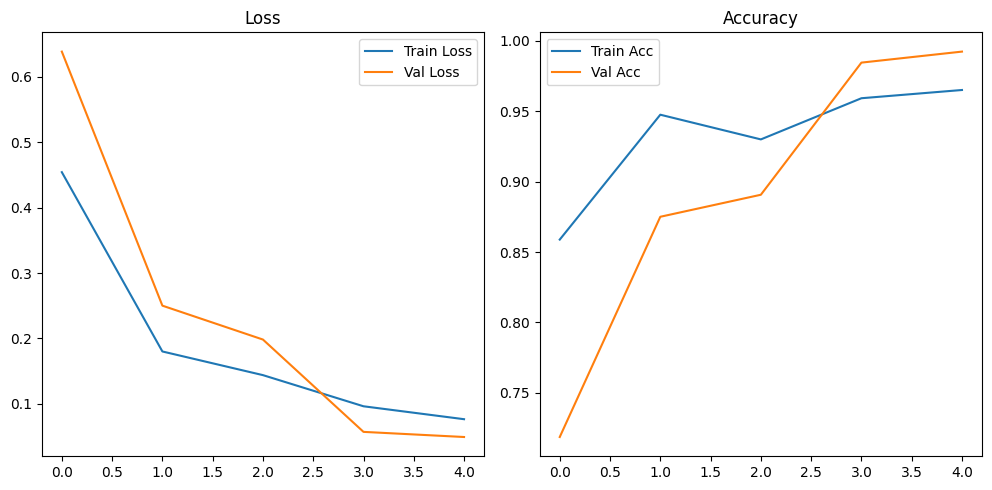

In [18]:
plt.figure(figsize=(15,5))

plt.subplot(1,3,1)
plt.plot(train_loss_list, label='Train Loss')
plt.plot(val_loss_list, label='Val Loss')
plt.title('Loss')
plt.legend()

plt.subplot(1,3,2)
plt.plot(train_acc_list, label='Train Acc')
plt.plot(val_acc_list, label='Val Acc')
plt.title('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

ROC-кривая

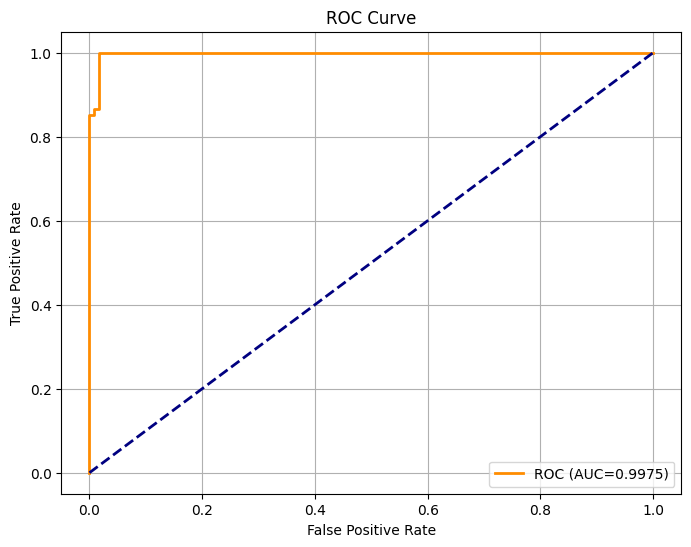

In [22]:
fpr, tpr, thresholds = roc_curve(targets, probs)
plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, label=f'ROC (AUC={auc_list[-1]:.4f})', color='darkorange', lw=2)
plt.plot([0,1],[0,1], linestyle='--', color='navy', lw=2)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

## Интерфейс для загрузки изображения и получения предсказания

In [33]:

def predict_image(model, image_path, transform, device):
    model.eval()
    img = Image.open(image_path).convert('RGB')
    img = transform(img).unsqueeze(0).to(device)
    
    with torch.no_grad():
        output = model(img)
        pred = (output > 0.5).float().item()
    
    label = "horse" if pred == 0 else "human"
    return label

Пример использования

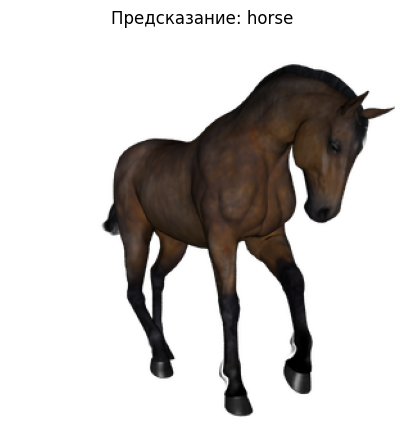

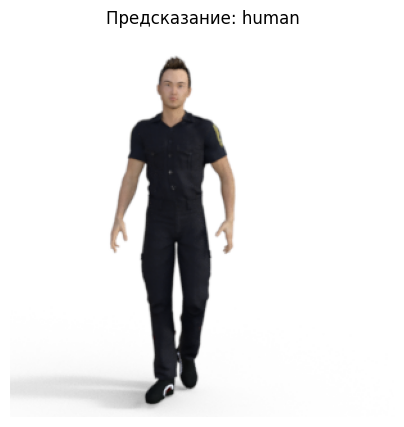

In [45]:
image_paths = [
    "horses-or-humans-dataset/horse-or-human/validation/horses/horse1-000.png",
    "horses-or-humans-dataset/horse-or-human/validation/humans/valhuman01-00.png"
]

for path in image_paths:
    result = predict_image(model, path, base_transforms, device)
    
    img = Image.open(path)
    
    plt.figure(figsize=(5,5))
    plt.imshow(img)
    plt.title(f"Предсказание: {result}")
    plt.axis('off')
    plt.show()